# Image Classification
In this project, you'll classify images from the [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html).  The dataset consists of airplanes, dogs, cats, and other objects. You'll preprocess the images, then train a convolutional neural network on all the samples. The images need to be normalized and the labels need to be one-hot encoded.  You'll get to apply what you learned and build a convolutional, max pooling, dropout, and fully connected layers.  At the end, you'll get to see your neural network's predictions on the sample images.
## Get the Data
Run the following cell to download the [CIFAR-10 dataset for python](https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz).

In [1]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import problem_unittests as tests
import tarfile

cifar10_dataset_folder_path = 'cifar-10-batches-py'

# Use Floyd's cifar-10 dataset if present
floyd_cifar10_location = '/input/cifar-10/python.tar.gz'
if isfile(floyd_cifar10_location):
    tar_gz_path = floyd_cifar10_location
else:
    tar_gz_path = 'cifar-10-python.tar.gz'

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(tar_gz_path):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='CIFAR-10 Dataset') as pbar:
        urlretrieve(
            'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
            tar_gz_path,
            pbar.hook)

if not isdir(cifar10_dataset_folder_path):
    with tarfile.open(tar_gz_path) as tar:
        tar.extractall()
        tar.close()


tests.test_folder_path(cifar10_dataset_folder_path)

All files found!


## Explore the Data
The dataset is broken into batches to prevent your machine from running out of memory.  The CIFAR-10 dataset consists of 5 batches, named `data_batch_1`, `data_batch_2`, etc.. Each batch contains the labels and images that are one of the following:
* airplane
* automobile
* bird
* cat
* deer
* dog
* frog
* horse
* ship
* truck

Understanding a dataset is part of making predictions on the data.  Play around with the code cell below by changing the `batch_id` and `sample_id`. The `batch_id` is the id for a batch (1-5). The `sample_id` is the id for a image and label pair in the batch.

Ask yourself "What are all possible labels?", "What is the range of values for the image data?", "Are the labels in order or random?".  Answers to questions like these will help you preprocess the data and end up with better predictions.


Stats of batch 1:
Samples: 10000
Label Counts: {0: 1005, 1: 974, 2: 1032, 3: 1016, 4: 999, 5: 937, 6: 1030, 7: 1001, 8: 1025, 9: 981}
First 20 Labels: [6, 9, 9, 4, 1, 1, 2, 7, 8, 3, 4, 7, 7, 2, 9, 9, 9, 3, 2, 6]

Example of Image 5:
Image - Min Value: 0 Max Value: 252
Image - Shape: (32, 32, 3)
Label - Label Id: 1 Name: automobile


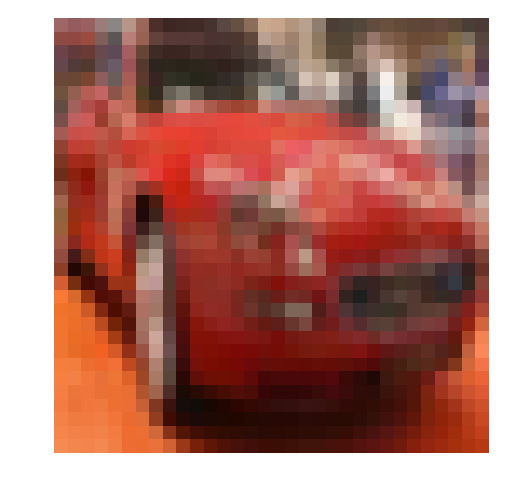

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import helper
import numpy as np

# Explore the dataset
batch_id = 1
sample_id = 5
helper.display_stats(cifar10_dataset_folder_path, batch_id, sample_id)

## Implement Preprocess Functions
### Normalize
In the cell below, implement the `normalize` function to take in image data, `x`, and return it as a normalized Numpy array. The values should be in the range of 0 to 1, inclusive.  The return object should be the same shape as `x`.

In [1]:
import problem_unittests as tests
import helper
import numpy as np
def normalize(x):
    """
    Normalize a list of sample image data in the range of 0 to 1
    : x: List of image data.  The image shape is (32, 32, 3)
    : return: Numpy array of normalize data
    """
    x = np.array(x, dtype = np.float)
    for i in range(len(x)):
        mean = np.mean(x[i, ...])
        # Use adjusted standard deviation here, in case the std == 0.
        std = np.max([np.std(x[i, ...]), 1.0/np.sqrt(32 * 32 * 3)])
        x[i,...] = (x[i, ...] - mean) / std
    return x

### One-hot encode
Just like the previous code cell, you'll be implementing a function for preprocessing.  This time, you'll implement the `one_hot_encode` function. The input, `x`, are a list of labels.  Implement the function to return the list of labels as One-Hot encoded Numpy array.  The possible values for labels are 0 to 9. The one-hot encoding function should return the same encoding for each value between each call to `one_hot_encode`.  Make sure to save the map of encodings outside the function.

Hint: Don't reinvent the wheel.

In [4]:
from sklearn import preprocessing
def one_hot_encode(x):
    
    """
    One hot encode a list of sample labels. Return a one-hot encoded vector for each label.
    : x: List of sample Labels
    : return: Numpy array of one-hot encoded labels
    """
     # TODO: Implement Function
    x = np.array(x)
    ohe = np.zeros((x.shape[0], 10))
    ohe[np.arange(x.shape[0]), x] = 1
    return ohe
    

### Randomize Data
As you saw from exploring the data above, the order of the samples are randomized.  It doesn't hurt to randomize it again, but you don't need to for this dataset.

## Preprocess all the data and save it
Running the code cell below will preprocess all the CIFAR-10 data and save it to file. The code below also uses 10% of the training data for validation.

In [5]:

# Preprocess Validation, and Testing D
helper.preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode)

# Check Point
This is your first checkpoint.  If you ever decide to come back to this notebook or have to restart the notebook, you can start from here.  The preprocessed data has been saved to disk.

In [2]:

import pickle
import problem_unittests as tests
import helper

# Load the Preprocessed Validation data
valid_features, valid_labels = pickle.load(open('preprocess_validation.p', mode='rb'))

## Build the network
For the neural network, you'll build each layer into a function.  Most of the code you've seen has been outside of functions. To test your code more thoroughly, we require that you put each layer in a function.  This allows us to give you better feedback and test for simple mistakes using our unittests before you submit your project.

If you're finding it hard to dedicate enough time for this course a week, we've provided a small shortcut to this part of the project. In the next couple of problems, you'll have the option to use [TensorFlow Layers](https://www.tensorflow.org/api_docs/python/tf/layers) or [TensorFlow Layers (contrib)](https://www.tensorflow.org/api_guides/python/contrib.layers) to build each layer, except "Convolutional & Max Pooling" layer.  TF Layers is similar to Keras's and TFLearn's abstraction to layers, so it's easy to pickup.

If you would like to get the most of this course, try to solve all the problems without TF Layers.  Let's begin!
### Input
The neural network needs to read the image data, one-hot encoded labels, and dropout keep probability. Implement the following functions
* Implement `neural_net_image_input`
 * Return a [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder)
 * Set the shape using `image_shape` with batch size set to `None`.
 * Name the TensorFlow placeholder "x" using the TensorFlow `name` parameter in the [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder).
* Implement `neural_net_label_input`
 * Return a [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder)
 * Set the shape using `n_classes` with batch size set to `None`.
 * Name the TensorFlow placeholder "y" using the TensorFlow `name` parameter in the [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder).
* Implement `neural_net_keep_prob_input`
 * Return a [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder) for dropout keep probability.
 * Name the TensorFlow placeholder "keep_prob" using the TensorFlow `name` parameter in the [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder).

These names will be used at the end of the project to load your saved model.

Note: `None` for shapes in TensorFlow allow for a dynamic size.

In [3]:
import tensorflow as tf

def neural_net_image_input(image_shape):
    """
    Return a Tensor for a bach of image input
    : image_shape: Shape of the images
    : return: Tensor for image input.
    """
    return tf.placeholder(tf.float32,[None,image_shape[0], image_shape[1], image_shape[2]], name = 'x')


def neural_net_label_input(n_classes):
    """
    Return a Tensor for a batch of label input
    : n_classes: Number of classes
    : return: Tensor for label input.
    """
    
    return tf.placeholder(tf.float32, [None,n_classes], name = 'y')


def neural_net_keep_prob_input():
    """
    Return a Tensor for keep probability
    : return: Tensor for keep probability.
    """
    return tf.placeholder(tf.float32, name = 'keep_prob')



### Convolution and Max Pooling Layer
Convolution layers have a lot of success with images. For this code cell, you should implement the function `conv2d_maxpool` to apply convolution then max pooling:
* Create the weight and bias using `conv_ksize`, `conv_num_outputs` and the shape of `x_tensor`.
* Apply a convolution to `x_tensor` using weight and `conv_strides`.
 * We recommend you use same padding, but you're welcome to use any padding.
* Add bias
* Add a nonlinear activation to the convolution.
* Apply Max Pooling using `pool_ksize` and `pool_strides`.
 * We recommend you use same padding, but you're welcome to use any padding.

Note: You **can't** use [TensorFlow Layers](https://www.tensorflow.org/api_docs/python/tf/layers) or [TensorFlow Layers (contrib)](https://www.tensorflow.org/api_guides/python/contrib.layers) for this layer.  You're free to use any TensorFlow package for all the other layers.

In [4]:
def batch_norm(input_layer, dimension):
    mean, variance = tf.nn.moments(input_layer, axes=[0, 1, 2])
    beta = tf.Variable(tf.zeros([dimension]))
    gamma = tf.Variable(tf.ones([dimension]))
    bn_layer = tf.nn.batch_normalization(input_layer, mean, variance, beta, gamma, 0.001)

    return bn_layer
    
    

In [5]:
def maxpool(x_tensor, pool_ksize, pool_strides):
    return tf.nn.max_pool(x_tensor, ksize = [1, pool_ksize[0], pool_ksize[1], 1], strides = [1, pool_strides[0], pool_strides[1], 1], padding = 'VALID')


In [6]:
def avgpool(x_tensor, pool_ksize, pool_strides):
    return tf.nn.avg_pool(x_tensor, ksize = [1, pool_ksize[0], pool_ksize[1], 1], strides = [1, pool_strides[0], pool_strides[1], 1], padding = 'VALID')

    

In [7]:
from math import sqrt
def conv2d(x_tensor, conv_num_outputs, conv_ksize, conv_strides, weight):
    """
    Apply convolution then max pooling to x_tensor
    :param x_tensor: TensorFlow Tensor
    :param conv_num_outputs: Number of outputs for the convolutional layer
    :param conv_strides: Stride 2-D Tuple for convolution
    :param pool_ksize: kernal size 2-D Tuple for pool
    :param pool_strides: Stride 2-D Tuple for pool
    : return: A tensor that represents convolution and max pooling of x_tensor
    """
    # TODO: Implement Function
    x_shape = x_tensor.get_shape().as_list()
    regularizer = tf.contrib.layers.l2_regularizer(scale=0.0001)
    n = conv_ksize[0] * conv_ksize[1] * conv_num_outputs
    weights = tf.get_variable(weight, shape=[conv_ksize[0], conv_ksize[1], x_shape[3], conv_num_outputs],
                              initializer=tf.random_normal_initializer(stddev=np.sqrt(2.0/n)), regularizer = regularizer)
 
    L = tf.nn.conv2d(x_tensor, weights, strides = [1, conv_strides[0], conv_strides[1], 1], padding='SAME')
    return L
    

In [8]:
def elu(L):
    return tf.nn.relu(L)            


### Flatten Layer
Implement the `flatten` function to change the dimension of `x_tensor` from a 4-D tensor to a 2-D tensor.  The output should be the shape (*Batch Size*, *Flattened Image Size*). You can use [TensorFlow Layers](https://www.tensorflow.org/api_docs/python/tf/layers) or [TensorFlow Layers (contrib)](https://www.tensorflow.org/api_guides/python/contrib.layers) for this layer.

In [9]:
def flatten(layer):
    """
    Flatten x_tensor to (Batch Size, Flattened Image Size)
    : x_tensor: A tensor of size (Batch Size, ...), where ... are the image dimensions.
    : return: A tensor of size (Batch Size, Flattened Image Size).
    """
    return tf.contrib.layers.flatten(layer)
    

### Fully-Connected Layer
Implement the `fully_conn` function to apply a fully connected layer to `x_tensor` with the shape (*Batch Size*, *num_outputs*). You can use [TensorFlow Layers](https://www.tensorflow.org/api_docs/python/tf/layers) or [TensorFlow Layers (contrib)](https://www.tensorflow.org/api_guides/python/contrib.layers) for this layer.

In [10]:
def fully_conn(x_tensor, num_outputs):
    """
    Apply a fully connected layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    # TODO: Implement Function
    x = tf.contrib.layers.fully_connected(x_tensor, num_outputs = num_outputs, weights_initializer = tf.random_normal_initializer(mean=0.0, stddev=0.05, seed=None, dtype=tf.float32))
    x = tf.nn.elu(x)

    
    return x



### Output Layer
Implement the `output` function to apply a fully connected layer to `x_tensor` with the shape (*Batch Size*, *num_outputs*). You can use [TensorFlow Layers](https://www.tensorflow.org/api_docs/python/tf/layers) or [TensorFlow Layers (contrib)](https://www.tensorflow.org/api_guides/python/contrib.layers) for this layer.

Note: Activation, softmax, or cross entropy shouldn't be applied to this.

In [11]:
def output(x_tensor, num_outputs):
    """
    Apply a output layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    # TODO: Implement Function
    x_shape = x_tensor.get_shape().as_list()
    regularizer = tf.contrib.layers.l2_regularizer(scale=0.0001)
    
    weights = tf.get_variable('weight', shape= [x_shape[1], num_outputs],
                              initializer=tf.uniform_unit_scaling_initializer(factor=1.0), regularizer =regularizer)
    bias = tf.Variable(tf.zeros([num_outputs]))
    out = tf.add(tf.matmul(x_tensor, weights), bias)
    
    return out



In [12]:
import cv2
def horizontal_flip(image, axis):
    '''
    Flip an image at 50% possibility
    :param image: a 3 dimensional numpy array representing an image
    :param axis: 0 for vertical flip and 1 for horizontal flip
    :return: 3D image after flip
    '''
    flip_prop = np.random.randint(low=0, high=2)
    if flip_prop == 0:
        image = cv2.flip(image, axis)

    return image




def random_crop_and_flip(batch_data):
    '''
    Helper to random crop and random flip a batch of images
    :param padding_size: int. how many layers of 0 padding was added to each side
    :param batch_data: a 4D batch array
    :return: randomly cropped and flipped image
    '''
    cropped_batch = np.zeros(len(batch_data) * 32 * 32 * 3).reshape(
        len(batch_data), 32, 32, 3)
    padded_batch = np.zeros(len(batch_data) * 40 * 40 * 3).reshape(
        len(batch_data), 40, 40, 3)
    padded_batch[:,4:36,4:36,:] = batch_data 

    for i in range(len(batch_data)):
        x_offset = np.random.randint(low=0, high=2 * 4, size=1)[0]
        y_offset = np.random.randint(low=0, high=2 * 4, size=1)[0]

        
        
        cropped_batch[i, ...] = padded_batch[i, ...][x_offset:x_offset+32,
                      y_offset:y_offset+32, :]

        cropped_batch[i, ...] = horizontal_flip(image=cropped_batch[i, ...], axis=1)

    return cropped_batch

In [13]:
 def generate_augment_train_batch(train_data, train_labels, train_batch_size):
        '''
        This function helps generate a batch of train data, and random crop, horizontally flip
        and whiten them at the same time
        :param train_data: 4D numpy array
        :param train_labels: 1D numpy array
        :param train_batch_size: int
        :return: augmented train batch data and labels. 4D numpy array and 1D numpy array
        '''
        batch_data = random_crop_and_flip(train_data)
        batch_label = train_labels
        return batch_data, batch_label

### Create Convolutional Model
Implement the function `conv_net` to create a convolutional neural network model. The function takes in a batch of images, `x`, and outputs logits.  Use the layers you created above to create this model:

* Apply 1, 2, or 3 Convolution and Max Pool layers
* Apply a Flatten Layer
* Apply 1, 2, or 3 Fully Connected Layers
* Apply an Output Layer
* Return the output
* Apply [TensorFlow's Dropout](https://www.tensorflow.org/api_docs/pyhon/tf/nn/dropout) to one or more layers in the model using `keep_prob`. 

In [14]:
def conv_net(x, keep_prob):
    conv1 = conv2d(x, 16, (3,3), (1,1), 'weights1')
    conv1 = batch_norm(conv1, 16)
    conv = elu(conv1)
    #resnet-1(32 x 32)
    conv1 = batch_norm(conv, 16)
    conv1 = elu(conv1)
    conv2 = conv2d(conv1, 16, (1,1), (1,1), 'weights2')
    conv2 = batch_norm(conv2, 16)
    conv2 = elu(conv2)
    conv2 = conv2d(conv2, 16, (3,3), (1,1), 'weights3')
    conv2 = batch_norm(conv2, 16)
    conv2 = elu(conv2)
    conv2 = conv2d(conv2, 64, (1,1), (1,1), 'weights4')
    conv = tf.pad(conv, [[0,0], [0,0], [0,0], [24, 24]])
    conv = (conv + conv2)
    
    #resnet-2
    conv2 = batch_norm(conv, 64)
    conv2 = elu(conv2)
    conv2 = conv2d(conv2, 16, (1,1), (1,1), 'weights5')
    conv2 = batch_norm(conv2, 16)
    conv2 = elu(conv2)
    conv2 = conv2d(conv2, 16, (3,3), (1,1), 'weights6')
    conv2 = batch_norm(conv2, 16)
    conv2 = elu(conv2)
    conv2 = conv2d(conv2, 64, (1,1), (1,1), 'weights7')
    conv = (conv + conv2)
    #resnet-3
    conv2 = batch_norm(conv, 64)
    conv2 = elu(conv2)
    conv2 = conv2d(conv2, 16, (1,1), (1,1), 'weights8')
    conv2 = batch_norm(conv2, 16)
    conv2 = elu(conv2)
    conv2 = conv2d(conv2, 16, (3,3), (1,1), 'weights9')
    conv2 = batch_norm(conv2, 16)
    conv2 = elu(conv2)
    conv2 = conv2d(conv2, 64, (1,1), (1,1), 'weights10')
    conv = (conv + conv2)
    #resnet-4
    conv2 = batch_norm(conv, 64)
    conv2 = elu(conv2)
    conv2 = conv2d(conv2, 16, (1,1), (1,1), 'weights11')
    conv2 = batch_norm(conv2, 16)
    conv2 = elu(conv2)
    conv2 = conv2d(conv2, 16, (3,3), (1,1), 'weights12')
    conv2 = batch_norm(conv2, 16)
    conv2 = elu(conv2)
    conv2 = conv2d(conv2, 64, (1,1), (1,1), 'weights13')
    conv = (conv + conv2)
    #resnet-5
    conv2 = batch_norm(conv, 64)
    conv2 = elu(conv2)
    conv2 = conv2d(conv2, 16, (1,1), (1,1), 'weights14')
    conv2 = batch_norm(conv2, 16)
    conv2 = elu(conv2)
    conv2 = conv2d(conv2, 16, (3,3), (1,1), 'weights15')
    conv2 = batch_norm(conv2, 16)
    conv2 = elu(conv2)
    conv2 = conv2d(conv2, 64, (1,1), (1,1), 'weights16')
    conv = (conv + conv2)
    
    #resnet-6
    conv2 = batch_norm(conv, 64)
    conv2 = elu(conv2)
    conv2 = conv2d(conv2, 16, (1,1), (1,1), 'weights17')
    conv2 = batch_norm(conv2, 16)
    conv2 = elu(conv2)
    conv2 = conv2d(conv2, 16, (3,3), (1,1), 'weights18')
    conv2 = batch_norm(conv2, 16)
    conv2 = elu(conv2)
    conv2 = conv2d(conv2, 64, (1,1), (1,1), 'weights19')
    conv = (conv + conv2)
    
    
    
    #resnet-7
    conv2 = batch_norm(conv, 64)
    conv2 = elu(conv2)
    conv2 = conv2d(conv2, 16, (1,1), (1,1), 'weights20')
    conv2 = batch_norm(conv2, 16)
    conv2 = elu(conv2)
    conv2 = conv2d(conv2, 16, (3,3), (1,1), 'weights21')
    conv2 = batch_norm(conv2, 16)
    conv2 = elu(conv2)
    conv2 = conv2d(conv2, 64, (1,1), (1,1), 'weights22')
    conv = (conv + conv2)
    
    
    #resnet-8
    conv2 = batch_norm(conv, 64)
    conv2 = elu(conv2)
    conv2 = conv2d(conv2, 16, (1,1), (1,1), 'weights23')
    conv2 = batch_norm(conv2, 16)
    conv2 = elu(conv2)
    conv2 = conv2d(conv2, 16, (3,3), (1,1), 'weights24')
    conv2 = batch_norm(conv2, 16)
    conv2 = elu(conv2)
    conv2 = conv2d(conv2, 64, (1,1), (1,1), 'weights25')
    conv = (conv + conv2)
    
    #resnet-9
    conv2 = batch_norm(conv, 64)
    conv2 = elu(conv2)
    conv2 = conv2d(conv2, 16, (1,1), (1,1), 'weights26')
    conv2 = batch_norm(conv2, 16)
    conv2 = elu(conv2)
    conv2 = conv2d(conv2, 16, (3,3), (1,1), 'weights27')
    conv2 = batch_norm(conv2, 16)
    conv2 = elu(conv2)
    conv2 = conv2d(conv2, 64, (1,1), (1,1), 'weights28')
    conv = (conv + conv2)
    
    #resnet-10
    conv2 = batch_norm(conv, 64)
    conv2 = elu(conv2)
    conv2 = conv2d(conv2, 16, (1,1), (1,1), 'weights29')
    conv2 = batch_norm(conv2, 16)
    conv2 = elu(conv2)
    conv2 = conv2d(conv2, 16, (3,3), (1,1), 'weights30')
    conv2 = batch_norm(conv2, 16)
    conv2 = elu(conv2)
    conv2 = conv2d(conv2, 64, (1,1), (1,1), 'weights31')
    conv = (conv + conv2)
    
    #resnet-11
    conv2 = batch_norm(conv, 64)
    conv2 = elu(conv2)
    conv2 = conv2d(conv2, 16, (1,1), (1,1), 'weights32')
    conv2 = batch_norm(conv2, 16)
    conv2 = elu(conv2)
    conv2 = conv2d(conv2, 16, (3,3), (1,1), 'weights33')
    conv2 = batch_norm(conv2, 16)
    conv2 = elu(conv2)
    conv2 = conv2d(conv2, 64, (1,1), (1,1), 'weights34')
    conv = (conv + conv2)
    
    #resnet-12
    conv2 = batch_norm(conv, 64)
    conv2 = elu(conv2)
    conv2 = conv2d(conv2, 16, (1,1), (1,1), 'weights35')
    conv2 = batch_norm(conv2, 16)
    conv2 = elu(conv2)
    conv2 = conv2d(conv2, 16, (3,3), (1,1), 'weights36')
    conv2 = batch_norm(conv2, 16)
    conv2 = elu(conv2)
    conv2 = conv2d(conv2, 64, (1,1), (1,1), 'weights37')
    conv = (conv + conv2)
    
    #resnet-13
    conv2 = batch_norm(conv, 64)
    conv2 = elu(conv2)
    conv2 = conv2d(conv2, 16, (1,1), (1,1), 'weights38')
    conv2 = batch_norm(conv2, 16)
    conv2 = elu(conv2)
    conv2 = conv2d(conv2, 16, (3,3), (1,1), 'weights39')
    conv2 = batch_norm(conv2, 16)
    conv2 = elu(conv2)
    conv2 = conv2d(conv2, 64, (1,1), (1,1), 'weights40')
    conv = (conv + conv2)
    
    #resnet-14
    conv2 = batch_norm(conv, 64)
    conv2 = elu(conv2)
    conv2 = conv2d(conv2, 16, (1,1), (1,1), 'weights41')
    conv2 = batch_norm(conv2, 16)
    conv2 = elu(conv2)
    conv2 = conv2d(conv2, 16, (3,3), (1,1), 'weights42')
    conv2 = batch_norm(conv2, 16)
    conv2 = elu(conv2)
    conv2 = conv2d(conv2, 64, (1,1), (1,1), 'weights43')
    conv = (conv + conv2)
    
    #resnet-15
    conv2 = batch_norm(conv, 64)
    conv2 = elu(conv2)
    conv2 = conv2d(conv2, 16, (1,1), (1,1), 'weights44')
    conv2 = batch_norm(conv2, 16)
    conv2 = elu(conv2)
    conv2 = conv2d(conv2, 16, (3,3), (1,1), 'weights45')
    conv2 = batch_norm(conv2, 16)
    conv2 = elu(conv2)
    conv2 = conv2d(conv2, 64, (1,1), (1,1), 'weights46')
    conv = (conv + conv2)
    
    #resnet-16
    conv2 = batch_norm(conv, 64)
    conv2 = elu(conv2)
    conv2 = conv2d(conv2, 16, (1,1), (1,1), 'weights47')
    conv2 = batch_norm(conv2, 16)
    conv2 = elu(conv2)
    conv2 = conv2d(conv2, 16, (3,3), (1,1), 'weights48')
    conv2 = batch_norm(conv2, 16)
    conv2 = elu(conv2)
    conv2 = conv2d(conv2, 64, (1,1), (1,1), 'weights49')
    conv = (conv + conv2)
    
    #resnet-17
    conv2 = batch_norm(conv, 64)
    conv2 = elu(conv2)
    conv2 = conv2d(conv2, 16, (1,1), (1,1), 'weights50')
    conv2 = batch_norm(conv2, 16)
    conv2 = elu(conv2)
    conv2 = conv2d(conv2, 16, (3,3), (1,1), 'weights51')
    conv2 = batch_norm(conv2, 16)
    conv2 = elu(conv2)
    conv2 = conv2d(conv2, 64, (1,1), (1,1), 'weights52')
    conv = (conv + conv2)
    
    #resnet-18
    conv2 = batch_norm(conv, 64)
    conv2 = elu(conv2)
    conv2 = conv2d(conv2, 16, (1,1), (1,1), 'weights53')
    conv2 = batch_norm(conv2, 16)
    conv2 = elu(conv2)
    conv2 = conv2d(conv2, 16, (3,3), (1,1), 'weights54')
    conv2 = batch_norm(conv2, 16)
    conv2 = elu(conv2)
    conv2 = conv2d(conv2, 64, (1,1), (1,1), 'weights55')
    conv = (conv + conv2)
    

    
    
    #resnet-19(16 x 16)
    conv4 = batch_norm(conv, 64)
    conv4 = elu(conv4) 
    conv4 = conv2d(conv4, 32, (1,1), (2,2), 'weights56')
    conv4 = batch_norm(conv4, 32)
    conv4 = elu(conv4) 
    conv4 = conv2d(conv4, 32, (3,3), (1,1), 'weights57')
    conv4 = batch_norm(conv4, 32)
    conv4 = elu(conv4)    
    conv4 = conv2d(conv4, 128, (1,1), (1,1), 'weights58')
    conv =  avgpool(conv, (2,2), (2,2))
    conv_p = tf.pad(conv, [[0,0], [0,0], [0,0], [32, 32]])
    conv = (conv4 + conv_p)
    
    #resnet-20
    conv4 = batch_norm(conv, 128)
    conv4 = elu(conv4)
    conv4 = conv2d(conv4, 32, (1,1), (1,1), 'weights59')
    conv4 = batch_norm(conv4, 32)
    conv4 = elu(conv4)
    conv4 = conv2d(conv4, 32, (3,3), (1,1), 'weights60')
    conv4 = batch_norm(conv4, 32)
    conv4 = elu(conv4)
    conv4 = conv2d(conv4, 128, (1,1), (1,1), 'weights61')
    conv = (conv4 + conv)
    
    
    #resnet-21
    conv4 = batch_norm(conv, 128)
    conv4 = elu(conv4)
    conv4 = conv2d(conv4, 32, (1,1), (1,1), 'weights62')
    conv4 = batch_norm(conv4, 32)
    conv4 = elu(conv4)
    conv4 = conv2d(conv4, 32, (3,3), (1,1), 'weights63')
    conv4 = batch_norm(conv4, 32)
    conv4 = elu(conv4)
    conv4 = conv2d(conv4, 128, (1,1), (1,1), 'weights64')
    conv = (conv4 + conv)
    
    #resnet-22
    conv4 = batch_norm(conv, 128)
    conv4 = elu(conv4)
    conv4 = conv2d(conv4, 32, (1,1), (1,1), 'weights65')
    conv4 = batch_norm(conv4, 32)
    conv4 = elu(conv4)
    conv4 = conv2d(conv4, 32, (3,3), (1,1), 'weights66')
    conv4 = batch_norm(conv4, 32)
    conv4 = elu(conv4)
    conv4 = conv2d(conv4, 128, (1,1), (1,1), 'weights67')
    conv = (conv4 + conv)
    
    #resnet-23
    conv4 = batch_norm(conv, 128)
    conv4 = elu(conv4)
    conv4 = conv2d(conv4, 32, (1,1), (1,1), 'weights68')
    conv4 = batch_norm(conv4, 32)
    conv4 = elu(conv4)
    conv4 = conv2d(conv4, 32, (3,3), (1,1), 'weights69')
    conv4 = batch_norm(conv4, 32)
    conv4 = elu(conv4)
    conv4 = conv2d(conv4, 128, (1,1), (1,1), 'weights70')
    conv = (conv4 + conv)
    
    #resnet-24
    conv4 = batch_norm(conv, 128)
    conv4 = elu(conv4)
    conv4 = conv2d(conv4, 32, (1,1), (1,1), 'weights71')
    conv4 = batch_norm(conv4, 32)
    conv4 = elu(conv4)
    conv4 = conv2d(conv4, 32, (3,3), (1,1), 'weights72')
    conv4 = batch_norm(conv4, 32)
    conv4 = elu(conv4)
    conv4 = conv2d(conv4, 128, (1,1), (1,1), 'weights73')
    conv = (conv4 + conv)
    
    #resnet-25
    conv4 = batch_norm(conv, 128)
    conv4 = elu(conv4)
    conv4 = conv2d(conv4, 32, (1,1), (1,1), 'weights74')
    conv4 = batch_norm(conv4, 32)
    conv4 = elu(conv4)
    conv4 = conv2d(conv4, 32, (3,3), (1,1), 'weights75')
    conv4 = batch_norm(conv4, 32)
    conv4 = elu(conv4)
    conv4 = conv2d(conv4, 128, (1,1), (1,1), 'weights76')
    conv = (conv4 + conv)
    
    #resnet-26
    conv4 = batch_norm(conv, 128)
    conv4 = elu(conv4)
    conv4 = conv2d(conv4, 32, (1,1), (1,1), 'weights77')
    conv4 = batch_norm(conv4, 32)
    conv4 = elu(conv4)
    conv4 = conv2d(conv4, 32, (3,3), (1,1), 'weights78')
    conv4 = batch_norm(conv4, 32)
    conv4 = elu(conv4)
    conv4 = conv2d(conv4, 128, (1,1), (1,1), 'weights79')
    conv = (conv4 + conv)
    
    #resnet-27
    conv4 = batch_norm(conv, 128)
    conv4 = elu(conv4)
    conv4 = conv2d(conv4, 32, (1,1), (1,1), 'weights80')
    conv4 = batch_norm(conv4, 32)
    conv4 = elu(conv4)
    conv4 = conv2d(conv4, 32, (3,3), (1,1), 'weights81')
    conv4 = batch_norm(conv4, 32)
    conv4 = elu(conv4)
    conv4 = conv2d(conv4, 128, (1,1), (1,1), 'weights82')
    conv = (conv4 + conv)
    
     #resnet-28
    conv4 = batch_norm(conv, 128)
    conv4 = elu(conv4)
    conv4 = conv2d(conv4, 32, (1,1), (1,1), 'weights83')
    conv4 = batch_norm(conv4, 32)
    conv4 = elu(conv4)
    conv4 = conv2d(conv4, 32, (3,3), (1,1), 'weights84')
    conv4 = batch_norm(conv4, 32)
    conv4 = elu(conv4)
    conv4 = conv2d(conv4, 128, (1,1), (1,1), 'weights85')
    conv = (conv4 + conv)
    
     #resnet-29
    conv4 = batch_norm(conv, 128)
    conv4 = elu(conv4)
    conv4 = conv2d(conv4, 32, (1,1), (1,1), 'weights86')
    conv4 = batch_norm(conv4, 32)
    conv4 = elu(conv4)
    conv4 = conv2d(conv4, 32, (3,3), (1,1), 'weights87')
    conv4 = batch_norm(conv4, 32)
    conv4 = elu(conv4)
    conv4 = conv2d(conv4, 128, (1,1), (1,1), 'weights88')
    conv = (conv4 + conv)
    
     #resnet-30
    conv4 = batch_norm(conv, 128)
    conv4 = elu(conv4)
    conv4 = conv2d(conv4, 32, (1,1), (1,1), 'weights89')
    conv4 = batch_norm(conv4, 32)
    conv4 = elu(conv4)
    conv4 = conv2d(conv4, 32, (3,3), (1,1), 'weights90')
    conv4 = batch_norm(conv4, 32)
    conv4 = elu(conv4)
    conv4 = conv2d(conv4, 128, (1,1), (1,1), 'weights91')
    conv = (conv4 + conv)
    
     #resnet-31
    conv4 = batch_norm(conv, 128)
    conv4 = elu(conv4)
    conv4 = conv2d(conv4, 32, (1,1), (1,1), 'weights92')
    conv4 = batch_norm(conv4, 32)
    conv4 = elu(conv4)
    conv4 = conv2d(conv4, 32, (3,3), (1,1), 'weights93')
    conv4 = batch_norm(conv4, 32)
    conv4 = elu(conv4)
    conv4 = conv2d(conv4, 128, (1,1), (1,1), 'weights94')
    conv = (conv4 + conv)
    
     #resnet-32
    conv4 = batch_norm(conv, 128)
    conv4 = elu(conv4)
    conv4 = conv2d(conv4, 32, (1,1), (1,1), 'weights95')
    conv4 = batch_norm(conv4, 32)
    conv4 = elu(conv4)
    conv4 = conv2d(conv4, 32, (3,3), (1,1), 'weights96')
    conv4 = batch_norm(conv4, 32)
    conv4 = elu(conv4)
    conv4 = conv2d(conv4, 128, (1,1), (1,1), 'weights97')
    conv = (conv4 + conv)
    
     #resnet-33
    conv4 = batch_norm(conv, 128)
    conv4 = elu(conv4)
    conv4 = conv2d(conv4, 32, (1,1), (1,1), 'weights98')
    conv4 = batch_norm(conv4, 32)
    conv4 = elu(conv4)
    conv4 = conv2d(conv4, 32, (3,3), (1,1), 'weights99')
    conv4 = batch_norm(conv4, 32)
    conv4 = elu(conv4)
    conv4 = conv2d(conv4, 128, (1,1), (1,1), 'weights100')
    conv = (conv4 + conv)
    
     #resnet-34
    conv4 = batch_norm(conv, 128)
    conv4 = elu(conv4)
    conv4 = conv2d(conv4, 32, (1,1), (1,1), 'weights101')
    conv4 = batch_norm(conv4, 32)
    conv4 = elu(conv4)
    conv4 = conv2d(conv4, 32, (3,3), (1,1), 'weights102')
    conv4 = batch_norm(conv4, 32)
    conv4 = elu(conv4)
    conv4 = conv2d(conv4, 128, (1,1), (1,1), 'weights103')
    conv = (conv4 + conv)
    
     #resnet-35
    conv4 = batch_norm(conv, 128)
    conv4 = elu(conv4)
    conv4 = conv2d(conv4, 32, (1,1), (1,1), 'weights104')
    conv4 = batch_norm(conv4, 32)
    conv4 = elu(conv4)
    conv4 = conv2d(conv4, 32, (3,3), (1,1), 'weights105')
    conv4 = batch_norm(conv4, 32)
    conv4 = elu(conv4)
    conv4 = conv2d(conv4, 128, (1,1), (1,1), 'weights106')
    conv = (conv4 + conv)
    
     #resnet-36
    conv4 = batch_norm(conv, 128)
    conv4 = elu(conv4)
    conv4 = conv2d(conv4, 32, (1,1), (1,1), 'weights107')
    conv4 = batch_norm(conv4, 32)
    conv4 = elu(conv4)
    conv4 = conv2d(conv4, 32, (3,3), (1,1), 'weights108')
    conv4 = batch_norm(conv4, 32)
    conv4 = elu(conv4)
    conv4 = conv2d(conv4, 128, (1,1), (1,1), 'weights109')
    conv = (conv4 + conv)
    
    
    
    #resnet-37
    conv6 = batch_norm(conv, 128)
    conv6 = elu(conv6)
    conv6 = conv2d(conv6, 64, (1,1), (2,2), 'weights110')
    conv6 = batch_norm(conv6, 64)
    conv6 = elu(conv6)
    conv6 = conv2d(conv6, 64, (3,3), (1,1), 'weights111')
    conv6 = batch_norm(conv6, 64)
    conv6 = elu(conv6)
    conv6 = conv2d(conv6, 256, (1,1), (1,1), 'weights112')
    conv =  avgpool(conv, (2,2), (2,2))
    conv_p = tf.pad(conv, [[0,0], [0,0], [0,0], [64,64]])
    
    conv = (conv6 + conv_p)
    
    #resnet-38(8 x 8)
    conv6 = batch_norm(conv, 256)
    conv6 = elu(conv6)
    conv6 = conv2d(conv6, 64, (1,1), (1,1), 'weights113')
    conv6 = batch_norm(conv6, 64)
    conv6 = elu(conv6)
    conv6 = conv2d(conv6, 64, (3,3), (1,1), 'weights114')
    conv6 = batch_norm(conv6, 64)
    conv6 = elu(conv6)
    conv6 = conv2d(conv6, 256, (1,1), (1,1), 'weights115')  
    conv = (conv6 + conv)
    
    #resnet-39
    conv6 = batch_norm(conv, 256)
    conv6 = elu(conv6)
    conv6 = conv2d(conv6, 64, (1,1), (1,1), 'weights116')
    conv6 = batch_norm(conv6, 64)
    conv6 = elu(conv6)
    conv6 = conv2d(conv6, 64, (3,3), (1,1), 'weights117')
    conv6 = batch_norm(conv6, 64)
    conv6 = elu(conv6)
    conv6 = conv2d(conv6, 256, (1,1), (1,1), 'weights118')  
    conv = (conv6 + conv)
    
    #resnet-40
    conv6 = batch_norm(conv, 256)
    conv6 = elu(conv6)
    conv6 = conv2d(conv6, 64, (1,1), (1,1), 'weights119')
    conv6 = batch_norm(conv6, 64)
    conv6 = elu(conv6)
    conv6 = conv2d(conv6, 64, (3,3), (1,1), 'weights120')
    conv6 = batch_norm(conv6, 64)
    conv6 = elu(conv6)
    conv6 = conv2d(conv6, 256, (1,1), (1,1), 'weights121')  
    conv = (conv6 + conv)
    
    #resnet-41
    conv6 = batch_norm(conv, 256)
    conv6 = elu(conv6)
    conv6 = conv2d(conv6, 64, (1,1), (1,1), 'weights122')
    conv6 = batch_norm(conv6, 64)
    conv6 = elu(conv6)
    conv6 = conv2d(conv6, 64, (3,3), (1,1), 'weights123')
    conv6 = batch_norm(conv6, 64)
    conv6 = elu(conv6)
    conv6 = conv2d(conv6, 256, (1,1), (1,1), 'weights124')  
    conv = (conv6 + conv)
    
    #resnet-42
    conv6 = batch_norm(conv, 256)
    conv6 = elu(conv6)
    conv6 = conv2d(conv6, 64, (1,1), (1,1), 'weights125')
    conv6 = batch_norm(conv6, 64)
    conv6 = elu(conv6)
    conv6 = conv2d(conv6, 64, (3,3), (1,1), 'weights126')
    conv6 = batch_norm(conv6, 64)
    conv6 = elu(conv6)
    conv6 = conv2d(conv6, 256, (1,1), (1,1), 'weights127')  
    conv = (conv6 + conv)
    
    
    #resnet-43
    conv6 = batch_norm(conv, 256)
    conv6 = elu(conv6)
    conv6 = conv2d(conv6, 64, (1,1), (1,1), 'weights128')
    conv6 = batch_norm(conv6, 64)
    conv6 = elu(conv6)
    conv6 = conv2d(conv6, 64, (3,3), (1,1), 'weights129')
    conv6 = batch_norm(conv6, 64)
    conv6 = elu(conv6)
    conv6 = conv2d(conv6, 256, (1,1), (1,1), 'weights130')  
    conv = (conv6 + conv)
    
    
    #resnet-44
    conv6 = batch_norm(conv, 256)
    conv6 = elu(conv6)
    conv6 = conv2d(conv6, 64, (1,1), (1,1), 'weights163')
    conv6 = batch_norm(conv6, 64)
    conv6 = elu(conv6)
    conv6 = conv2d(conv6, 64, (3,3), (1,1), 'weights131')
    conv6 = batch_norm(conv6, 64)
    conv6 = elu(conv6)
    conv6 = conv2d(conv6, 256, (1,1), (1,1), 'weights132')  
    conv = (conv6 + conv)
    
    #resnet-45
    conv6 = batch_norm(conv, 256)
    conv6 = elu(conv6)
    conv6 = conv2d(conv6, 64, (1,1), (1,1), 'weights133')
    conv6 = batch_norm(conv6, 64)
    conv6 = elu(conv6)
    conv6 = conv2d(conv6, 64, (3,3), (1,1), 'weights134')
    conv6 = batch_norm(conv6, 64)
    conv6 = elu(conv6)
    conv6 = conv2d(conv6, 256, (1,1), (1,1), 'weights135')  
    conv = (conv6 + conv)
    
    
    #resnet-46
    conv6 = batch_norm(conv, 256)
    conv6 = elu(conv6)
    conv6 = conv2d(conv6, 64, (1,1), (1,1), 'weights136')
    conv6 = batch_norm(conv6, 64)
    conv6 = elu(conv6)
    conv6 = conv2d(conv6, 64, (3,3), (1,1), 'weights137')
    conv6 = batch_norm(conv6, 64)
    conv6 = elu(conv6)
    conv6 = conv2d(conv6, 256, (1,1), (1,1), 'weights138')  
    conv = (conv6 + conv)
    
     #resnet-47
    conv6 = batch_norm(conv, 256)
    conv6 = elu(conv6)
    conv6 = conv2d(conv6, 64, (1,1), (1,1), 'weights139')
    conv6 = batch_norm(conv6, 64)
    conv6 = elu(conv6)
    conv6 = conv2d(conv6, 64, (3,3), (1,1), 'weights140')
    conv6 = batch_norm(conv6, 64)
    conv6 = elu(conv6)
    conv6 = conv2d(conv6, 256, (1,1), (1,1), 'weights141')  
    conv = (conv6 + conv)
    
     #resnet-46
    conv6 = batch_norm(conv, 256)
    conv6 = elu(conv6)
    conv6 = conv2d(conv6, 64, (1,1), (1,1), 'weights142')
    conv6 = batch_norm(conv6, 64)
    conv6 = elu(conv6)
    conv6 = conv2d(conv6, 64, (3,3), (1,1), 'weights143')
    conv6 = batch_norm(conv6, 64)
    conv6 = elu(conv6)
    conv6 = conv2d(conv6, 256, (1,1), (1,1), 'weights144')  
    conv = (conv6 + conv)
    
     #resnet-46
    conv6 = batch_norm(conv, 256)
    conv6 = elu(conv6)
    conv6 = conv2d(conv6, 64, (1,1), (1,1), 'weights145')
    conv6 = batch_norm(conv6, 64)
    conv6 = elu(conv6)
    conv6 = conv2d(conv6, 64, (3,3), (1,1), 'weights146')
    conv6 = batch_norm(conv6, 64)
    conv6 = elu(conv6)
    conv6 = conv2d(conv6, 256, (1,1), (1,1), 'weights147')  
    conv = (conv6 + conv)
    
     #resnet-46
    conv6 = batch_norm(conv, 256)
    conv6 = elu(conv6)
    conv6 = conv2d(conv6, 64, (1,1), (1,1), 'weights148')
    conv6 = batch_norm(conv6, 64)
    conv6 = elu(conv6)
    conv6 = conv2d(conv6, 64, (3,3), (1,1), 'weights149')
    conv6 = batch_norm(conv6, 64)
    conv6 = elu(conv6)
    conv6 = conv2d(conv6, 256, (1,1), (1,1), 'weights150')  
    conv = (conv6 + conv)
    
     #resnet-46
    conv6 = batch_norm(conv, 256)
    conv6 = elu(conv6)
    conv6 = conv2d(conv6, 64, (1,1), (1,1), 'weights151')
    conv6 = batch_norm(conv6, 64)
    conv6 = elu(conv6)
    conv6 = conv2d(conv6, 64, (3,3), (1,1), 'weights152')
    conv6 = batch_norm(conv6, 64)
    conv6 = elu(conv6)
    conv6 = conv2d(conv6, 256, (1,1), (1,1), 'weights153')  
    conv = (conv6 + conv)
    
     #resnet-46
    conv6 = batch_norm(conv, 256)
    conv6 = elu(conv6)
    conv6 = conv2d(conv6, 64, (1,1), (1,1), 'weights154')
    conv6 = batch_norm(conv6, 64)
    conv6 = elu(conv6)
    conv6 = conv2d(conv6, 64, (3,3), (1,1), 'weights155')
    conv6 = batch_norm(conv6, 64)
    conv6 = elu(conv6)
    conv6 = conv2d(conv6, 256, (1,1), (1,1), 'weights156')  
    conv = (conv6 + conv)
    
     #resnet-53
    conv6 = batch_norm(conv, 256)
    conv6 = elu(conv6)
    conv6 = conv2d(conv6, 64, (1,1), (1,1), 'weights157')
    conv6 = batch_norm(conv6, 64)
    conv6 = elu(conv6)
    conv6 = conv2d(conv6, 64, (3,3), (1,1), 'weights158')
    conv6 = batch_norm(conv6, 64)
    conv6 = elu(conv6)
    conv6 = conv2d(conv6, 256, (1,1), (1,1), 'weights159')  
    conv = (conv6 + conv)
    
     #resnet-54
    conv6 = batch_norm(conv, 256)
    conv6 = elu(conv6)
    conv6 = conv2d(conv6, 64, (1,1), (1,1), 'weights160')
    conv6 = batch_norm(conv6, 64)
    conv6 = elu(conv6)
    conv6 = conv2d(conv6, 64, (3,3), (1,1), 'weights161')
    conv6 = batch_norm(conv6, 64)
    conv6 = elu(conv6)
    conv6 = conv2d(conv6, 256, (1,1), (1,1), 'weights162')  
    conv = (conv6 + conv)
    conv = batch_norm(conv, 256)
    conv = elu(conv)
    
    #global avgpool
    conv =  tf.reduce_mean(conv, [1, 2])

    # TODO: Apply an Output Layer
    #    Set this to the number of classes
    # Function Definition from Above:
    #   output(x_tensor, num_outputs)
    out = output(conv, 10)
    return out



##############################
## Build the Neural Network ##
##############################
tf.reset_default_graph()
# Remove previous weights, bias, inputs, etc..
# Remove previous weights, bias, inputs, etc..
x = neural_net_image_input((32, 32, 3))
y = neural_net_label_input(10)
keep_prob = neural_net_keep_prob_input()
training =  tf.placeholder(tf.bool, name = 'training')
learning_rate =  tf.placeholder(tf.float32, shape =[])
global_step = tf.Variable(0, trainable=False)
# Model
 
logits = conv_net(x, keep_prob)

# Name logits Tensor, so that is can be loaded from disk after training
logits = tf.identity(logits, name='logits')

# Loss and Optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
starter_learning_rate = learning_rate
learn = tf.train.exponential_decay(starter_learning_rate, global_step, 100000, 0.96, staircase=True)
optimizer = tf.train.MomentumOptimizer(learning_rate=learn,use_nesterov=True,  momentum = 0.9).minimize(cost, global_step= global_step)

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1)) 
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')


## Train the Neural Network
### Single Optimization
Implement the function `train_neural_network` to do a single optimization.  The optimization should use `optimizer` to optimize in `session` with a `feed_dict` of the following:
* `x` for image input
* `y` for labels
* `keep_prob` for keep probability for dropout

This function will be called for each batch, so `tf.global_variables_initializer()` has already been called.

Note: Nothing needs to be returned. This function is only optimizing the neural network.

In [15]:
def train_neural_network(session, optimizer, keep_probability, feature_batch, label_batch, epoch):
    """
    Optimize the session on a batch of images and labels
    : session: Current TensorFlow session
    : optimizer: TensorFlow optimizer function
    : keep_probability: keep probability
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    """
    lr = None
    if epoch < 1:
        lr = 0.01
    elif epoch >= 1 and epoch < 80:
        lr = 0.1
    elif epoch>= 80 and epoch < 95 : 
        lr=  0.05
    else:
        lr = 0.01
    
    # TODO: Implement Function
    session.run(optimizer, feed_dict={x: feature_batch, y: label_batch, keep_prob: keep_probability, learning_rate : lr, training : True})



In [16]:
def print_stats(session, feature_batch, label_batch, cost, accuracy, epoch):
    lr = None
    """
    Print information about loss and validation accuracy
    : session: Current TensorFlow session
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    : cost: TensorFlow cost function
    : accuracy: TensorFlow accuracy function
    """
    
    if epoch < 1:
        lr = 0.01
    elif epoch >= 1 and epoch < 80:
        lr = 0.1
    elif epoch>= 80 and epoch < 95 : 
        lr=  0.05
    else:
        lr = 0.01
    # TODO: Implement Function
    loss = sess.run(cost, feed_dict={
                x: feature_batch,
                y: label_batch, 
                keep_prob: 1.0,
                learning_rate : lr, training : True})
    valid_acc = sess.run(accuracy, feed_dict={
                x: valid_features,
                y: valid_labels,
                keep_prob: 1.0,
                learning_rate : lr, training:False})
    print('Loss: {:>10.4f} Validation Accuracy: {:.6f}'.format(loss, valid_acc))

### Show Stats
Implement the function `print_stats` to print loss and validation accuracy.  Use the global variables `valid_features` and `valid_labels` to calculate validation accuracy.  Use a keep probability of `1.0` to calculate the loss and validation accuracy.

### Hyperparameters
Tune the following parameters:
* Set `epochs` to the number of iterations until the network stops learning or start overfitting
* Set `batch_size` to the highest number that your machine has memory for.  Most people set them to common sizes of memory:
 * 64
 * 128
 * 256
 * ...
* Set `keep_probability` to the probability of keeping a node using dropout

In [17]:
# TODO: Tune Parameter
epochs = 125
batch_size = 128
keep_probability = 0.5


### Train on a Single CIFAR-10 Batch
Instead of training the neural network on all the CIFAR-10 batches of data, let's use a single batch. This should save time while you iterate on the model to get a better accuracy.  Once the final validation accuracy is 50% or greater, run the model on all the data in the next section.

### Fully Train the Model
Now that you got a good accuracy with a single CIFAR-10 batch, try it with all five batches.

In [ ]:

save_model_path = './image_classification'

print('Training...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        # Loop over all batches
        n_batches = 5
        for batch_i in range(1, n_batches + 1):
            for batch_features, batch_labels in helper.load_preprocess_training_batch(batch_i, batch_size):
                features, labels = generate_augment_train_batch(batch_features, batch_labels , batch_size)
                train_neural_network(sess, optimizer, keep_probability, features, labels,epoch)
            print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
            print_stats(sess, batch_features, batch_labels, cost, accuracy,epoch)
            
    # Save Model
    saver = tf.train.Saver()
    save_path = saver.save(sess, save_model_path)

Training...
Epoch  1, CIFAR-10 Batch 1:  Loss:     2.2182 Validation Accuracy: 0.225600
Epoch  1, CIFAR-10 Batch 2:  Loss:     2.0837 Validation Accuracy: 0.288000
Epoch  1, CIFAR-10 Batch 3:  Loss:     1.6744 Validation Accuracy: 0.336200
Epoch  1, CIFAR-10 Batch 4:  Loss:     1.8616 Validation Accuracy: 0.376800
Epoch  1, CIFAR-10 Batch 5:  Loss:     1.6021 Validation Accuracy: 0.401200
Epoch  2, CIFAR-10 Batch 1:  Loss:     1.2129 Validation Accuracy: 0.448400
Epoch  2, CIFAR-10 Batch 2:  Loss:     1.1161 Validation Accuracy: 0.488200
Epoch  2, CIFAR-10 Batch 3:  Loss:     0.9403 Validation Accuracy: 0.550000
Epoch  2, CIFAR-10 Batch 4:  Loss:     0.8276 Validation Accuracy: 0.601600
Epoch  2, CIFAR-10 Batch 5:  Loss:     0.6894 Validation Accuracy: 0.642400
Epoch  3, CIFAR-10 Batch 1:  Loss:     0.6355 Validation Accuracy: 0.656200
Epoch  3, CIFAR-10 Batch 2:  Loss:     0.7193 Validation Accuracy: 0.664400
Epoch  3, CIFAR-10 Batch 3:  Loss:     0.5362 Validation Accuracy: 0.706800


# Checkpoint
The model has been saved to disk.
## Test Model
Test your model against the test dataset.  This will be your final accuracy. You should have an accuracy greater than 50%. If you don't, keep tweaking the model architecture and parameters.

Testing Accuracy: 0.9075000208616256



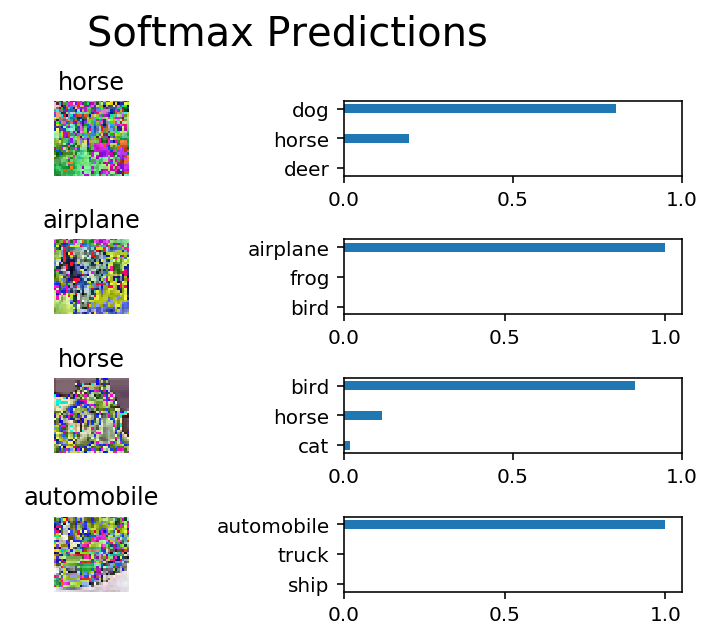

In [19]:

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import tensorflow as tf
import pickle
import helper
import random

# Set batch size if not already set
batch_size = 100

save_model_path = './image_classification'
n_samples = 4
top_n_predictions = 3

def test_model():
    """
    Test the saved model against the test dataset
    """

    test_features, test_labels = pickle.load(open('preprocess_training.p', mode='rb'))
    loaded_graph = tf.Graph()

    with tf.Session(graph=loaded_graph) as sess:
        # Load model
        loader = tf.train.import_meta_graph(save_model_path + '.meta')
        loader.restore(sess, save_model_path)

        # Get Tensors from loaded model
        loaded_x = loaded_graph.get_tensor_by_name('x:0')
        loaded_y = loaded_graph.get_tensor_by_name('y:0')
        loaded_keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')
        loaded_logits = loaded_graph.get_tensor_by_name('logits:0')
        loaded_acc = loaded_graph.get_tensor_by_name('accuracy:0')
        train = loaded_graph.get_tensor_by_name('training:0')
        
        # Get accuracy in batches for memory limitations
        test_batch_acc_total = 0
        test_batch_count = 0
        
        for train_feature_batch, train_label_batch in helper.batch_features_labels(test_features, test_labels, batch_size):
            test_batch_acc_total += sess.run(
                loaded_acc,
                feed_dict={loaded_x: train_feature_batch, loaded_y: train_label_batch, loaded_keep_prob: 1.0})
            test_batch_count += 1

        print('Testing Accuracy: {}\n'.format(test_batch_acc_total/test_batch_count))

        # Print Random Samples
        random_test_features, random_test_labels = tuple(zip(*random.sample(list(zip(test_features, test_labels)), n_samples)))
        random_test_predictions = sess.run(
            tf.nn.top_k(tf.nn.softmax(loaded_logits), top_n_predictions),
            feed_dict={loaded_x: random_test_features, loaded_y: random_test_labels, loaded_keep_prob: 1.0, train : False})
        helper.display_image_predictions(random_test_features, random_test_labels, random_test_predictions)


test_model()

## Why 50-70% Accuracy?
You might be wondering why you can't get an accuracy any higher. First things first, 50% isn't bad for a simple CNN.  Pure guessing would get you 10% accuracy. However, you might notice people are getting scores [well above 70%](http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html#43494641522d3130).  That's because we haven't taught you all there is to know about neural networks. We still need to cover a few more techniques.
## Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook.  Save the notebook file as "dlnd_image_classification.ipynb" and save it as a HTML file under "File" -> "Download as".  Include the "helper.py" and "problem_unittests.py" files in your submission.